# Semantic segmentation using U-net

## Exploring images and importing packages

In [1]:
import os
import imageio
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

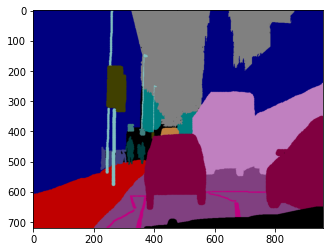

In [2]:
img = cv2.imread("CamVid\\train_labels\\0001TP_006690_L.png")
im2 = cv2.imread("CamVid\\train\\0001TP_006690.png")
#plt.imshow(im2)
plt.imshow(img)

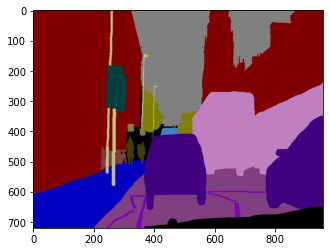

In [3]:
mask = cv2.imread("CamVid\\train_labels\\0001TP_006690_L.png")
mask = cv2.cvtColor((mask).astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.imshow(mask)

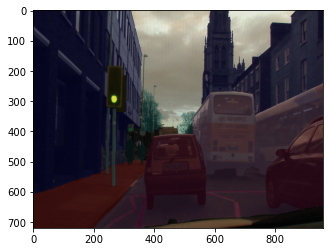

In [4]:

mask = cv2.imread("CamVid\\train_labels\\0001TP_006690_L.png")
image = cv2.imread("CamVid\\train\\0001TP_006690.png")
red = cv2.addWeighted(image,0.8,mask,0.2,0)
plt.imshow(red)

In [5]:
im2.shape

(720, 960, 3)

## Preprocessing masks
changing mask values from rgb to one hot encoded classes<br>
(w,h,3)-->(w,h,n_classes)

In [6]:
import pandas as pd
labels = pd.read_csv('labels.csv',index_col=0)
labels.head()

,r,g,b
label,,,
Animal,64,128,64
Archway,192,0,128
Bicyclist,0,128,192
Bridge,0,128,64
Building,128,0,0


In [7]:
mapping_dict = {label:list(labels.loc[label,:]) for label in labels.index}

In [8]:
type(mapping_dict['Animal'])

list

In [9]:
# changing mask
def preprocess_mask(classes,mask_img):
    ''' 
    preprocess the mask image to return OHE mask
    '''
    stack_list = []
    # 1- get the image(skipped for now)
    # 2- look for pixels = class pixels
    for cl in classes.values():
        equals = tf.equal(mask_img,cl)
    # 3- OHE those pixels in an array
        f = np.all(equals,axis=-1)
        ohe = tf.cast(f,dtype=tf.int32)
        stack_list.append(ohe)
    # 4- convert the array to a tensor
    annotations = tf.stack(stack_list,axis = -1)
    return annotations

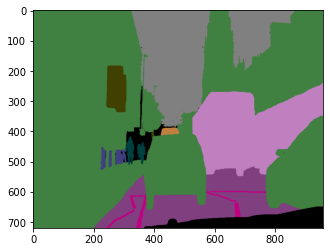

In [10]:
reverse_mask = {}
for idx ,(key,val) in enumerate(mapping_dict.items()):
    reverse_mask[idx] = np.array(val)
    
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(mapping_dict.items())}

    
reverse_mask[0]

def map_class_to_rgb(p):
  
  return idx2rgb[p[0]]


masked = preprocess_mask(mapping_dict,mask)
rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(masked, axis=-1), -1))
plt.imshow(rgb_mask)


## Data generators

In [11]:
# using image date generator Training dataset
DATA_PATH = "CamVid"
BATCH_SIZE = 4
SEED = 1
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1./255)

mask_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen  = ImageDataGenerator()

image_gen = image_datagen.flow_from_directory(
    directory=DATA_PATH,
    target_size=(256,256),
    classes=['train'],
    batch_size= BATCH_SIZE,
    seed=SEED,
    class_mode= None
)

label_gen = mask_datagen.flow_from_directory(
    directory=DATA_PATH,
    target_size=(256,256),
    classes=['train_labels'],
    batch_size= BATCH_SIZE,
    seed=SEED,
    class_mode= None,
    color_mode='rgb'
)

train_gen = zip(image_gen,label_gen)


def preprocess_train_gen():
    for (img,mask) in train_gen:
        mask_img = preprocess_mask(mapping_dict,mask)
        yield(img,mask_img)
        


Found 421 images belonging to 1 classes.
Found 421 images belonging to 1 classes.


In [12]:
image_gen_val = image_datagen.flow_from_directory(
    directory=DATA_PATH,
    target_size=(256,256),
    classes=['train'],
    batch_size= BATCH_SIZE,
    seed=SEED,
    class_mode= None
)

label_gen_val = mask_datagen.flow_from_directory(
    directory=DATA_PATH,
    target_size=(256,256),
    classes=['train_labels'],
    batch_size= BATCH_SIZE,
    seed=SEED,
    class_mode= None,
    color_mode='rgb'
)

val_gen = zip(image_gen,label_gen)


def preprocess_val_gen():
    for (img,mask) in val_gen:
        mask_img = preprocess_mask(mapping_dict,mask)
        yield(img,mask_img)
        
x = next(preprocess_val_gen())
x[0][0].shape

Found 421 images belonging to 1 classes.
Found 421 images belonging to 1 classes.


(256, 256, 3)

## Building model and training

In [13]:
# Unet Model
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,MaxPooling2D,Input,concatenate,Dropout,Activation
from tensorflow.keras.models import Model
# Encoder Block
def conv_block(inputs ,n_convs = 2,filters = 64 , 
               kernel_size = 3, kernel_initializer = 'glorot_uniform',
               activation = 'relu',padding = 'same',dropout = None,n=None):
    ''' 
    inputs : 
        prev_layer
        keras Conv2d layer parameters
        
    returns :
        n convolutional layers
    '''
    x = inputs
    for i in range(n_convs):
        x = Conv2D(filters= filters,
                   kernel_size= kernel_size,
                   kernel_initializer=kernel_initializer,
                   activation= activation,
                   padding = padding,
                   name = 'conv_'+str(i)+ '_' + str(n)
                   )(x)
    # renaming the last conv2d layer to be returned
    conv = x
    # applying max pooling to the last conv2d layer
    block = MaxPooling2D(pool_size=(2,2))(conv)
    if dropout : 
        block = Dropout(0.2)(conv)
        return block,conv
    else:
        return block,conv


def encoder(inputs,stage_filters = [64,128,256,512],bottle_neck_filters = 1024):
    ''' 
    Creates the encoder block of the Unet
    inputs : 
        inputs : tf tensor -model inputs
        stage_filters : list - number of filters for every downsampling stage
        bottle_neck_filters : int- number of bottle neck filters
    returns :
        x : encode block
        dict - convs : downsampling convolution outputs layers
    '''
    convs = {}
    x = inputs
    
    # conv blocks
    for stage in stage_filters:
        x,conv = conv_block(x,filters = stage,n=stage)
        convs['block_conv_'+str(stage)] = conv
    
    # bottle neck    
    x = Conv2D(kernel_size = (1,1),filters= bottle_neck_filters,name = 'bottle_neck')(x)
    
    return x,convs


In [14]:
# Decoder Block
def conv_trans_block(inputs,prev_conv,filters=64,kernel_size=(3,3),strides=(2,2),kernel_initializer='glorot_uniform',n = None):
    ''' 
    Builds an upsampling block 
    inputs :
        inputs : tensor - input from previous layer
        prev_conv : tensor - skip connection from equivilant downsampling
        Conv2D parameters
        Conv2DTranspose parameters
        
    returns :
        x : tensor - output of the upsampling block
    '''
    # up sampling
    up = Conv2DTranspose(filters = filters,
                         kernel_size = kernel_size,
                         strides = strides,padding = 'same',
                         kernel_initializer=kernel_initializer,
                         activation = 'relu',
                         name = 'transpose_conv_'+str(n)
                         )(inputs)
    # concat prev conv outputs
    x = concatenate([up,prev_conv],name = 'concatenate_layer_'+str(n))
    for i in range(2):
        x = Conv2D(filters= filters,
                   kernel_size= kernel_size,
                   kernel_initializer=kernel_initializer,
                   activation= 'relu',
                   padding = 'same',
                   name = 'conv_decoder_'+str(i)+ '_' + str(n)
                   )(x)
        
    return x

def decoder(inputs ,prev_convs ,n_classes,stage_filters = [512,256,128,64]):
    ''' 
    Builds Decoder block of the Unet
    inputs : 
        inputs : tensor - the output of the bottleneck
        prev_convs : dict - dictionary of the encoder convolutions for skip connections
        n_classes : number of classes for predictions to reshape output layer
        stage_filters : list - number of filters for each upsampling block
        
    returns :
        x : tensor - output layer of the model
    '''
    
    x = inputs
    stage = 0
    for conv in reversed(prev_convs.values()):
        x = conv_trans_block(x,conv,filters=stage_filters[stage],n = stage)
        stage+=1
        
    # Reshape output
    x = Conv2D(kernel_size = (1,1),filters= n_classes,name = 'reshaping_class_conv')(x)
    # Activation layer
    x = Activation('softmax',name = 'softmax_prediction')(x)
        
    return x
        

In [15]:
# making a unet model
def build_unet(input_shape,stage_filters,n_classes):
    ''' 
    Build a Unet model
    inputs : 
        input_shape : tuple - shape of input image
        stage_filters : list - number of filters for each downsampling stage
        n_classes : number of output classes
        
    return:
        model : Unet Tensorflow model
    '''
    
    inputs = Input(shape = input_shape,name = 'input_layer')
    
    encoder_out,convs = encoder(inputs,
                                stage_filters=stage_filters
                                )
    decoder_out = decoder(encoder_out,
                          prev_convs= convs,
                          stage_filters=list(reversed(stage_filters)),
                          n_classes=n_classes
                          )
    
    model = Model(inputs = inputs,outputs = decoder_out)
    return model

model = build_unet((256,256,3),stage_filters=[64,128,256,512],n_classes=32)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv_0_64 (Conv2D)              (None, 256, 256, 64) 1792        input_layer[0][0]                
__________________________________________________________________________________________________
conv_1_64 (Conv2D)              (None, 256, 256, 64) 36928       conv_0_64[0][0]                  
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv_1_64[0][0]                  
______________________________________________________________________________________________

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4) ,loss = 'categorical_crossentropy',metrics= ['accuracy'])

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
chk = ModelCheckpoint('unet_20.hdf5',monitor='val_loss',save_best_only=True,verbose=1)
history = model.fit_generator(preprocess_train_gen(),
                    validation_data=preprocess_val_gen(),
                    steps_per_epoch=421,
                    validation_steps=100,
                    epochs=20,
                    callbacks=[chk])

C:\Users\shehab\anaconda3\envs\py39DL\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
421/421 [==============================] - 276s 629ms/step - loss: 1.7281 - accuracy: 0.4836 - val_loss: 1.1160 - val_accuracy: 0.6810

Epoch 00001: val_loss improved from inf to 1.11601, saving model to unet_20.hdf5
Epoch 2/20
421/421 [==============================] - 261s 621ms/step - loss: 0.9587 - accuracy: 0.7324 - val_loss: 0.8383 - val_accuracy: 0.7705

Epoch 00002: val_loss improved from 1.11601 to 0.83826, saving model to unet_20.hdf5
Epoch 3/20
421/421 [==============================] - 260s 618ms/step - loss: 0.7725 - accuracy: 0.7865 - val_loss: 0.6756 - val_accuracy: 0.8142

Epoch 00003: val_loss improved from 0.83826 to 0.67562, saving model to unet_20.hdf5
Epoch 4/20
421/421 [==============================] - 261s 620ms/step - loss: 0.6460 - accuracy: 0.8190 - val_loss: 0.5688 - val_accuracy: 0.8370

Epoch 00004: val_loss improved from 0.67562 to 0.56884, saving model to unet_20.hdf5
Epoch 5/20
421/421 [==============================] - 262s 622ms/step - loss

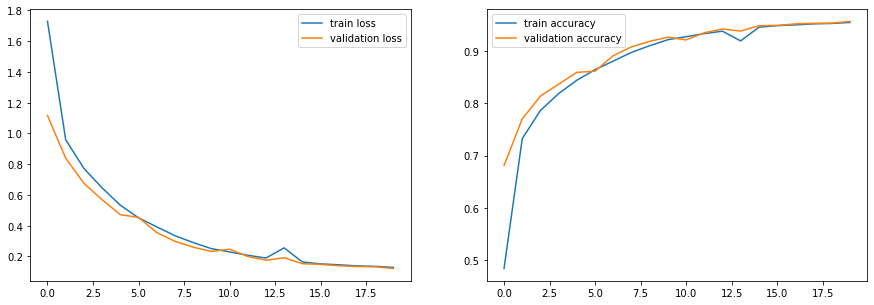

In [18]:
fig,ax = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].legend(['train loss','validation loss'])
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].legend(['train accuracy','validation accuracy'])

## Visualize and predict

In [17]:
def predict_visualize(image_path,alpha = 0.7):
    '''
    Predicts image mask and make overlayed mask for visaualization
    inputs :
        image_path : path for image to be predicted
        alpha : alpha value for mask overlay
        
    returns :
        pred : predicted mask image of shape (256,256,32)
        
    '''
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(256,256),interpolation = cv2.INTER_AREA)
    
    pred = model.predict(np.expand_dims(image,0)/255)
    
    pred = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(pred, axis=-1), -1))
    pred_vis = np.reshape(pred,(256,256,3))

    vis = cv2.addWeighted(image,1.,pred_vis,alpha,0, dtype = cv2.CV_32F)/255
    
    fig,ax = plt.subplots(1,3)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    ax[0].imshow(image)
    ax[1].imshow(pred_vis)
    ax[2].imshow(vis)
    #ax[2].imshow(pred_vis,alpha = alpha)
    
    ax[0].title.set_text('Image')
    ax[1].title.set_text('Predicted mask')
    ax[2].title.set_text('masked image')
    
    
    return pred_vis,image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


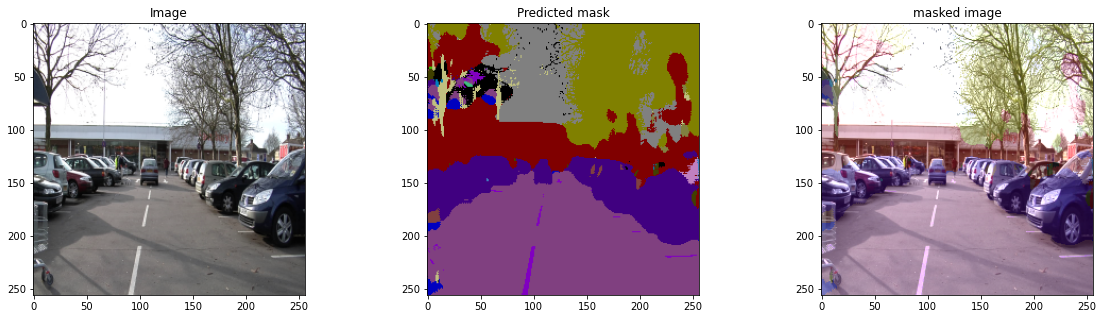

In [19]:
from tensorflow.keras.models import load_model
model.load_weights('unet_20.hdf5')
pred = predict_visualize("CamVid\\test\\0006R0_f02520.png",alpha = 0.4)


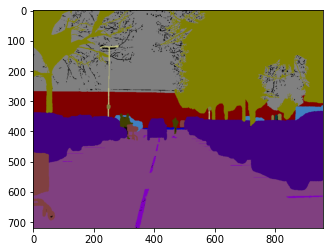

In [20]:
# show true mask
val = cv2.imread("CamVid\\test_labels\\0006R0_f02520_L.png")
val = cv2.cvtColor(val , cv2.COLOR_BGR2RGB)
plt.imshow(val)

## Create video/gif prediction for sequence of input images

In [43]:
# video prediction
def get_predictions_arr(images_path):
    '''
    Creates rgb and gbr predictions for sequence of images in a given folder
    inputs :
        images_path :string -  path to images folder
    return:
        gbr_list : list - contains gbr blended predictions
        rgb_list : list - contains rgb blended predictions
    '''
    # initialize empty lists
    gbr_list = []
    rgb_list = []
    
    # loop over images in dir
    for filename in os.listdir(images_path):
        # read image
        image = cv2.imread(os.path.join(images_path,filename))
        # resized GBR image
        resized_im = cv2.resize(image,(256,256),interpolation  = cv2.INTER_AREA)
        # convert to RGB for predictions
        rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        # resized rgb image
        resized_rgb = cv2.resize(rgb,(256,256),interpolation  = cv2.INTER_AREA)
        
        # Run infrence with model
        pred = model.predict(np.expand_dims(resized_rgb,0)/255)
        
        # convert prediction to image
        pred = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(pred, axis=-1), -1))
        pred_vis = np.squeeze(pred)
        pred_vis = np.array(pred_vis,dtype = np.uint8)
        
        # convert predicted image to BGR
        bgr = cv2.cvtColor(pred_vis,cv2.COLOR_RGB2BGR)
        # Get blended result
        vis_bgr = cv2.addWeighted(resized_im,0.7,bgr,0.3,0)
        
        # append to gbr list
        gbr_list.append(vis_bgr)
        
        # convert bgr blend to RGB
        vis_rgb = cv2.cvtColor(vis_bgr,cv2.COLOR_BGR2RGB)
        # append to RGB list
        rgb_list.append(vis_rgb)
        
    return gbr_list,rgb_list
        

In [49]:
# generate predictions
gbr,rgb = get_predictions_arr('CamVid/test')

In [53]:
# Create video
out = cv2.VideoWriter('output/cars.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 7, (256,256))
for im in gbr:
    out.write(im)

out.release()

# Create Gif
imageio.mimsave('output/cars.gif',rgb,fps = 7)
# gif parts
imageio.mimsave('output/cars_TP.gif',rgb[:28],fps = 7)
imageio.mimsave('output/cars_6R0.gif',rgb[28:52],fps = 7)
imageio.mimsave('output/cars_16E5.gif',rgb[52:126],fps = 7)
imageio.mimsave('output/cars_Seq05VD.gif',rgb[126:],fps = 7)

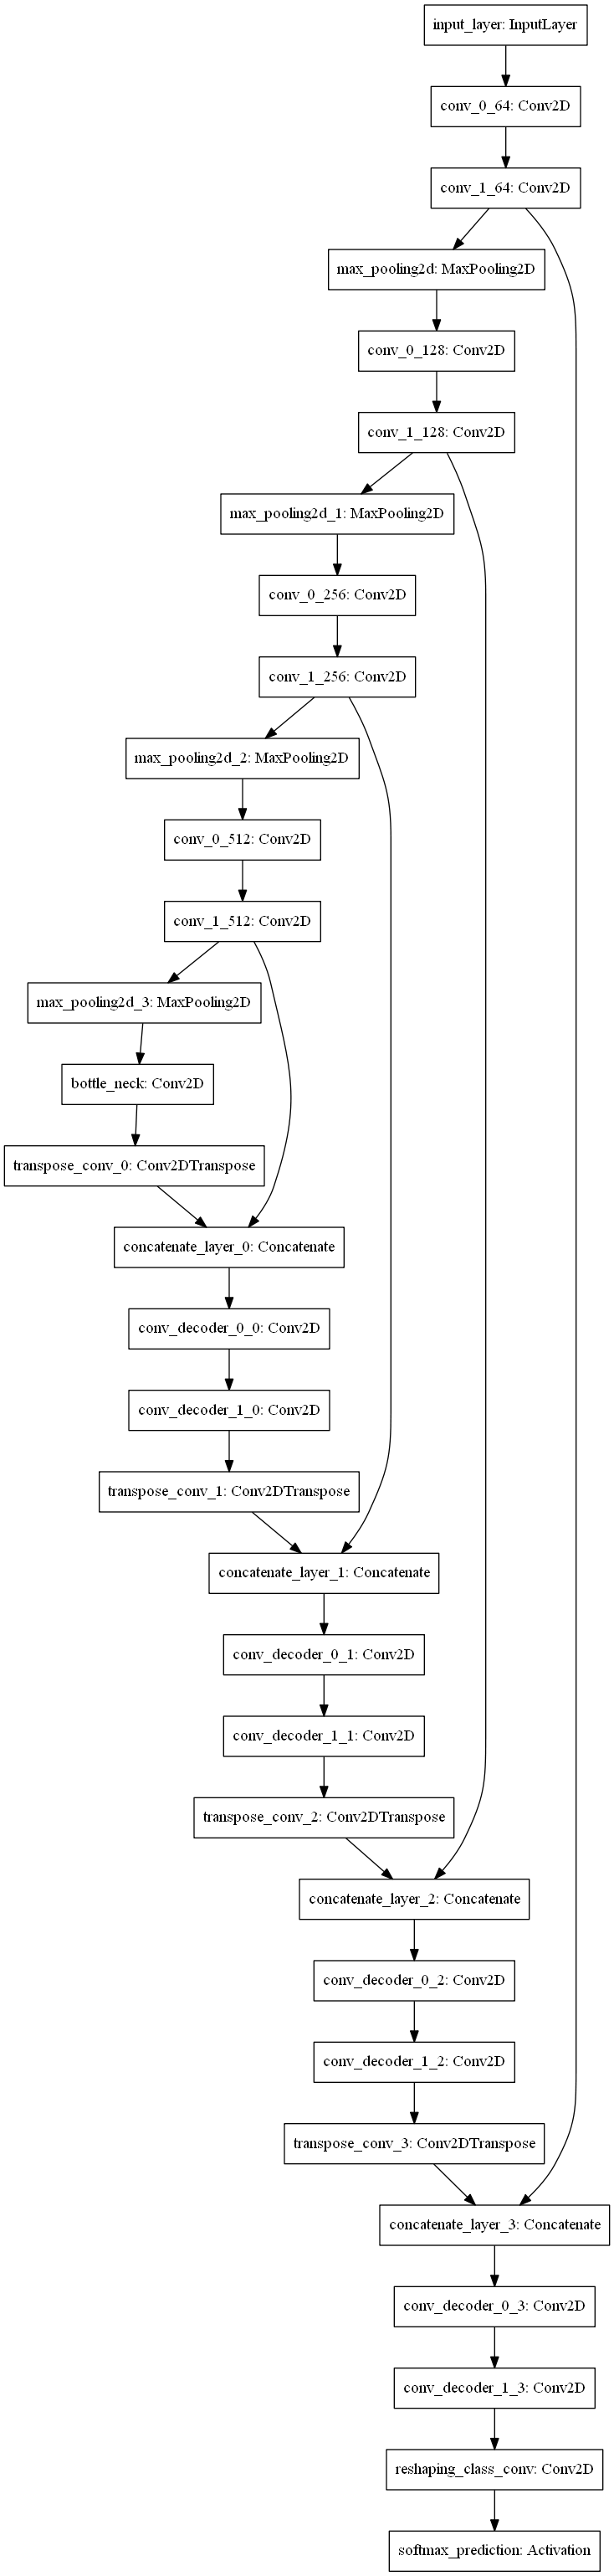

In [47]:
from tensorflow.keras.utils import plot_model
plot_model(model)